Study of the T-seed selection using BDT- XGBoost classifier
-----------------------------
This script contains all of my study based on **BDT - [XGBoost](https://github.com/dmlc/xgboost)**.  
I want to compare results of sklearn's GradientBoostedClassifier and XGBoost.  
[Rumour](https://github.com/dmlc/xgboost/blob/master/demo/README.md) has it that XGBoost is better than sklern's Gradient Boosted Classifier. We will see.  
The study contains simmilar steps as Baseline-BDT. 

Study roadmap 
--------------
1. Train  the first version of XGBoost with default parameters and without any features engeenering. Just to know baseline score. 
2. Add basic features transforamtion eg. pseudorapidity and abs. 
3. Tune hiperparameters at first number of trees and learining rate
4. Try to balance training dataset
4. Add linear combination and features's ratios  
   4.1 See at the learning curve. If needed perform step 3 for the new dataset.  
5. Speedup the algorithm using idea of [bonsai Decision Trees](http://arxiv.org/pdf/1210.6861v1.pdf)  
   I will use implementation of bBDT from [hep_ml](https://github.com/arogozhnikov/hep_ml/blob/master/hep_ml/speedup.py). 

The reslut to beat is 0.8131906
-----------


In [1]:
print ("kernel is alive!")

kernel is alive!


In [3]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report

from sklearn.externals import joblib

import xgboost as xgb

from hep_ml.speedup import LookupClassifier

As a very first step I need to grab training data form the NTpule. 
--------------------------

In [4]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980


Split data into train and validation sets
----------------------

In [5]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

In [ ]:
gb = xgb.XGBClassifier(max_depth=6, learning_rate=0.1,n_estimators = 100)
gb.fit(trainX,trainY)

In [9]:
print "ROC AUC score"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

ROC AUC score


0.79019802348145729

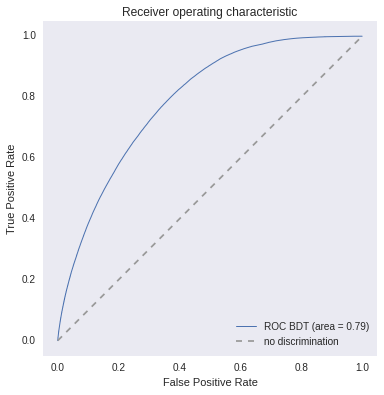

In [10]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Check importance of the features based on the BDT. 

Feature Engenering
======================
Add transformated features
-------------------
At the begining let's try some very basic feature transformation. 
I also add pseudorapidity and seed_r

In [6]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [7]:
new_data = basic_transforamtion(data)
new_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


In [15]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )

In [19]:
gb2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, subsample=0.8, max_depth=6)
gb2.fit(new_trainX,new_trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [20]:
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

0.80090517263682215

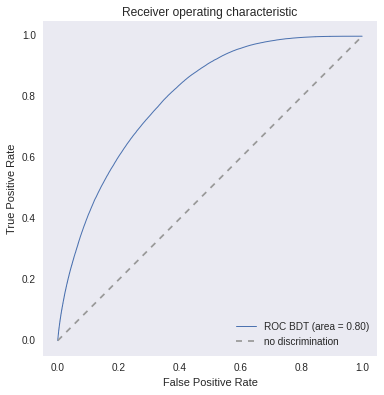

In [21]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameters optimalization
----------------
Let's improve it by serching for the best hyperparameters values. 
In the first iteration I want to find the best values of following hyperparameters 
* The cosidered range of n_estimators is between 50 and 250, step = 50
* learning rate in range 0.01-3 with semilogaritmic step

I use only 10% of data for grid search. Should be enough.


In [7]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(49,251) if x % 50 == 0],
                   "learning_rate": [0.01, 0.03,0.1,0.3,1]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier()

clf = grid_search.GridSearchCV(gb_gs,                               
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);


{'n_estimators': [50, 100, 150, 200, 250], 'learning_rate': [0.01, 0.03, 0.1, 0.3, 1]}
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=50, learning_rate=0.01 .............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=100, learning_rate=0.01 ............................
[CV] n_estimators=150, learning_rate=0.01 ............................
[CV] n_estimators=150, learning_rate=0.01 ............................
[CV] .... n_estimators=50, learning_rate=0.01, score=0.738884 -  48.3s


[Parallel(n_jobs=8)]: Done   1 jobs       | elapsed:   49.4s


[CV] n_estimators=150, learning_rate=0.01 ............................
[CV] .... n_estimators=50, learning_rate=0.01, score=0.740385 -  48.7s
[CV] n_estimators=200, learning_rate=0.01 ............................
[CV] .... n_estimators=50, learning_rate=0.01, score=0.741720 -  50.8s
[CV] n_estimators=200, learning_rate=0.01 ............................
[CV] ... n_estimators=100, learning_rate=0.01, score=0.742955 - 1.7min
[CV] n_estimators=200, learning_rate=0.01 ............................
[CV] ... n_estimators=100, learning_rate=0.01, score=0.741665 - 1.8min
[CV] n_estimators=250, learning_rate=0.01 ............................
[CV] ... n_estimators=100, learning_rate=0.01, score=0.745500 - 1.8min
[CV] n_estimators=250, learning_rate=0.01 ............................
[CV] ... n_estimators=150, learning_rate=0.01, score=0.744525 - 2.7min
[CV] n_estimators=250, learning_rate=0.01 ............................
[CV] ... n_estimators=150, learning_rate=0.01, score=0.746119 - 2.7min
[CV] n

[Parallel(n_jobs=8)]: Done  32 jobs       | elapsed: 10.3min


[CV] n_estimators=100, learning_rate=0.1 .............................
[CV] ... n_estimators=200, learning_rate=0.03, score=0.774847 - 4.0min
[CV] ..... n_estimators=50, learning_rate=0.1, score=0.772185 - 1.0min
[CV] n_estimators=100, learning_rate=0.1 .............................
[CV] n_estimators=150, learning_rate=0.1 .............................
[CV] ... n_estimators=200, learning_rate=0.03, score=0.769898 - 4.1min
[CV] n_estimators=150, learning_rate=0.1 .............................
[CV] ... n_estimators=250, learning_rate=0.03, score=0.772692 - 4.7min
[CV] n_estimators=150, learning_rate=0.1 .............................
[CV] .... n_estimators=100, learning_rate=0.1, score=0.780142 - 1.7min
[CV] n_estimators=200, learning_rate=0.1 .............................
[CV] .... n_estimators=100, learning_rate=0.1, score=0.775639 - 1.8min
[CV] n_estimators=200, learning_rate=0.1 .............................
[CV] .... n_estimators=100, learning_rate=0.1, score=0.779923 - 1.8min
[CV] n

[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 24.9min finished


In [8]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 250, 'learning_rate': 0.3}
Grid scores on development set:
0.740 (+/-0.002) for {'n_estimators': 50, 'learning_rate': 0.01}
0.743 (+/-0.003) for {'n_estimators': 100, 'learning_rate': 0.01}
0.746 (+/-0.002) for {'n_estimators': 150, 'learning_rate': 0.01}
0.750 (+/-0.003) for {'n_estimators': 200, 'learning_rate': 0.01}
0.753 (+/-0.004) for {'n_estimators': 250, 'learning_rate': 0.01}
0.746 (+/-0.002) for {'n_estimators': 50, 'learning_rate': 0.03}
0.757 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.03}
0.767 (+/-0.005) for {'n_estimators': 150, 'learning_rate': 0.03}
0.773 (+/-0.004) for {'n_estimators': 200, 'learning_rate': 0.03}
0.775 (+/-0.004) for {'n_estimators': 250, 'learning_rate': 0.03}
0.770 (+/-0.004) for {'n_estimators': 50, 'learning_rate': 0.1}
0.779 (+/-0.004) for {'n_estimators': 100, 'learning_rate': 0.1}
0.782 (+/-0.005) for {'n_estimators': 150, 'learning_rate': 0.1}
0.784 (+/-0.005) for {'n_e

In [9]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )
gb2 = xgb.XGBClassifier(learning_rate=0.3, n_estimators=250, max_depth=6)
gb2.fit(new_trainX,new_trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [10]:
print "ROC AUC score - model XGBoost with learning rate 0.3 and number of trees 250"
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

ROC AUC score - model XGBoost with learning rate 0.3 and number of trees 250


0.81758089824153213

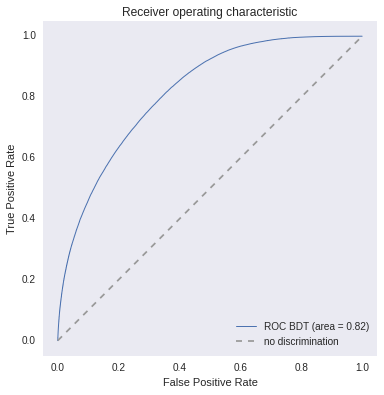

In [11]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Show dependency of BDT quality on the number of trees. 
----------
To obtain this values I use staged_predict_proba

In [ ]:
tree_scores = [] 
for tree_nb in range(1,249):
    proba = gb2.predict_proba(new_testX,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    tree_scores.append(score)

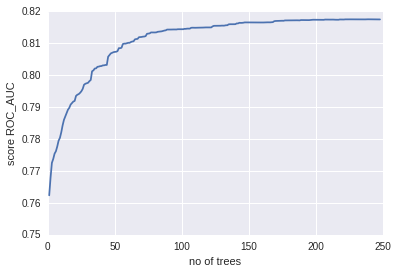

In [17]:
x = numpy.array([x  for x in range(1,249)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Save model to file 
-------
It is a good idea to save BDT parameters to file for further study.  
I use **sklearn.externals.joblib**. According to the documentation is more effitient than pickle. 

In [19]:
joblib.dump(gb2, 'models/XGBoost_200tree.pkl') 

['models/XGBoost_200tree.pkl',
 'models/XGBoost_200tree.pkl_01.npy',
 'models/XGBoost_200tree.pkl_02.npy']

Extend grid search  range of n_estimators to 600. 
-----------------
This time I want to increase classifier score via extending search space.  
I use data without linear feature transformations. 

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(299,601) if x % 50 == 0],
                   "learning_rate": [0.1,0.3,0.7,1]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier()

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);

In [8]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 450, 'learning_rate': 0.3}
Grid scores on development set:
0.787 (+/-0.005) for {'n_estimators': 300, 'learning_rate': 0.1}
0.788 (+/-0.005) for {'n_estimators': 350, 'learning_rate': 0.1}
0.789 (+/-0.006) for {'n_estimators': 400, 'learning_rate': 0.1}
0.790 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.1}
0.791 (+/-0.006) for {'n_estimators': 500, 'learning_rate': 0.1}
0.791 (+/-0.006) for {'n_estimators': 550, 'learning_rate': 0.1}
0.792 (+/-0.007) for {'n_estimators': 600, 'learning_rate': 0.1}
0.793 (+/-0.007) for {'n_estimators': 300, 'learning_rate': 0.3}
0.794 (+/-0.008) for {'n_estimators': 350, 'learning_rate': 0.3}
0.795 (+/-0.007) for {'n_estimators': 400, 'learning_rate': 0.3}
0.795 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.3}
0.795 (+/-0.005) for {'n_estimators': 500, 'learning_rate': 0.3}
0.794 (+/-0.005) for {'n_estimators': 550, 'learning_rate': 0.3}
0.794 (+/-0.006) for {'n_estimato

Train the new model
----------
* n_estimators 400
* learning rate 0.3

In [13]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )

gb3 = xgb.XGBClassifier( n_estimators=400, learning_rate=0.2, max_depth=6)
gb4.fit(train_X,train_y2)
joblib.dump(gb4, 'models/XGBoost_400_balanced.pkl') 

['models/XGBoost_400trees.pkl',
 'models/XGBoost_400trees.pkl_01.npy',
 'models/XGBoost_400trees.pkl_02.npy']

In [7]:
gb3 = joblib.load('models/XGBoost_400trees.pkl')
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              

In [14]:
print "ROC AUC score"
roc_auc_score(test_Y, gb3.predict_proba(test_X)[:, 1])

ROC AUC score


0.81908188341647703

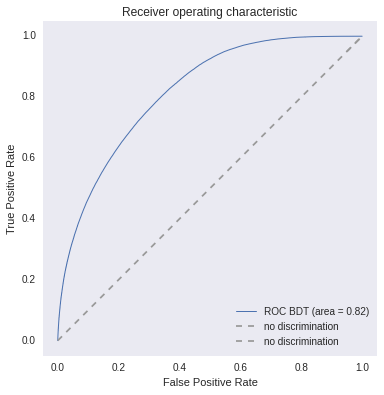

In [15]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

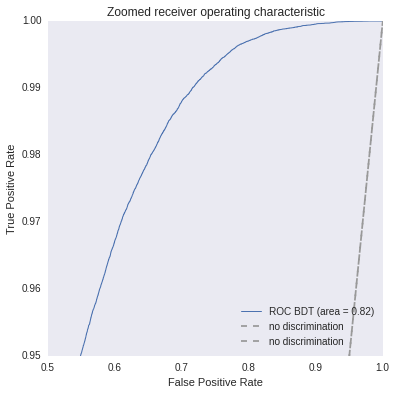

In [31]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb3.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.5, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb3.predict_proba(test_X,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(test_Y, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

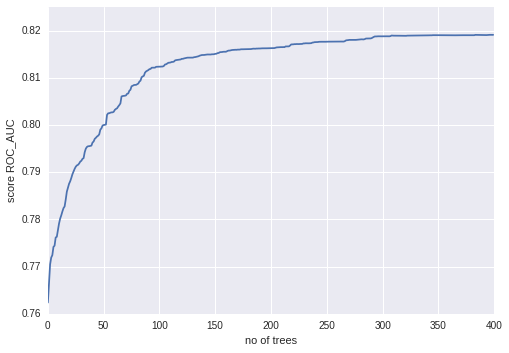

In [26]:
x = numpy.array([x  for x in range(400)])
plt.figure()
plt.plot(x,tree_scores[:400])
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Model comparison 
---------
In comparable to sklearn's model I obtained about 1% of improvement! This is quite nice. 

Balance dataset
--------------
Do to big data class misbalance I would like to balance it.  
First I split data into trainig and test sets and for training I grab only part of the ghost tracks. 

In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.8 )
train_good = train_X[train_Y == 1]
train_ghost = train_X[train_Y == 0]
nb_good_seeds = train_good.count()[0]
print (" ".join(["number of the good seeds",str(nb_good_seeds)]))
print (" ".join(["number of the ghost seeds",str(train_ghost.count()[0])]))
train_ghost=train_ghost.head(nb_good_seeds)
train_X=pd.concat([train_ghost, train_good])
train_X.head()
train_y2 =train_Y[train_X.index]

number of the good seeds 143025
number of the ghost seeds 2113155


In [9]:
gb4 = xgb.XGBClassifier(learning_rate=0.3, n_estimators=400, max_depth=6)
gb4.fit(train_X,train_y2)
joblib.dump(gb4, 'models/XGBoost_400_balanced.pkl') 

['models/XGBoost_400_balanced.pkl',
 'models/XGBoost_400_balanced.pkl_01.npy',
 'models/XGBoost_400_balanced.pkl_02.npy']

In [10]:
print "ROC AUC score of XGBoost with 400 trees and trained using equal number of good and ghost seeds"
roc_auc_score(test_Y, gb4.predict_proba(test_X)[:, 1])

ROC AUC score of XGBoost with 400 trees and trained using equal number of good and ghost seeds


0.81356480459444547

In [ ]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb4.predict_proba(test_X,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(test_Y, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

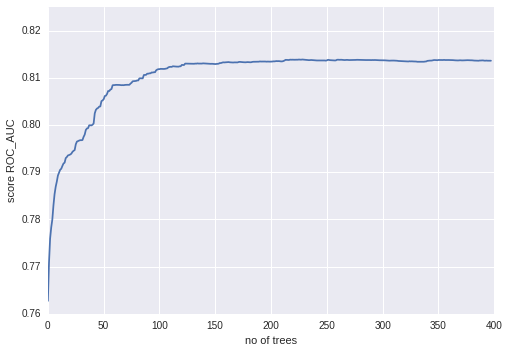

In [15]:
plt.figure()
plt.plot(tree_scores)
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

This balanced approach has no influence on classifier performance. 
------------

Balance via xgboost paramerer
-----------
I found parameter to be set. 
<font color="red"> I know I am dumb!!!!! </font>


In [9]:
good_track_no = counts = new_features[target == 1].count()[0]
ghost_track_no = counts = new_features[target == 0].count()[0]
print("good tracks %d") % good_track_no
print("ghost track %d") % ghost_track_no
ratio_ghost_to_good = float(ghost_track_no)/good_track_no
ratio_ghost_to_good = numpy.round(ratio_ghost_to_good, 3)
print ("ratio ghost to good %f") % ratio_ghost_to_good

good tracks 178831
ghost track 2641394
ratio ghost to good 14.770000


In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              
gb6 = xgb.XGBClassifier( n_estimators=400, learning_rate=0.2, scale_pos_weight=ratio_ghost_to_good, max_depth=6)
gb6.fit(train_X,train_Y)
joblib.dump(gb6, 'models/XGBoost_400_balanced2.pkl') 

['models/XGBoost_400_balanced2.pkl',
 'models/XGBoost_400_balanced2.pkl_01.npy',
 'models/XGBoost_400_balanced2.pkl_02.npy']

In [8]:
print "ROC AUC score of XGBoost with 400 trees and trained using scale positive weight"
roc_auc_score(test_Y, gb6.predict_proba(test_X)[:, 1])

ROC AUC score of XGBoost with 400 trees and trained using scale positive weight


0.8168021694229628

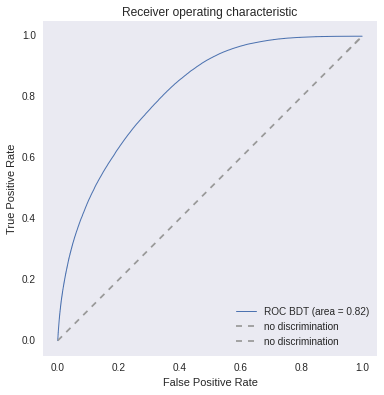

In [10]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb6.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

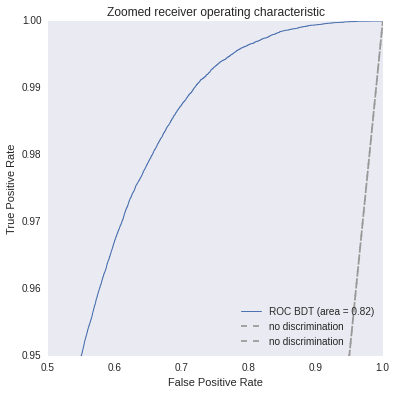

In [11]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb6.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.5, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb6.predict_proba(test_X,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(test_Y, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

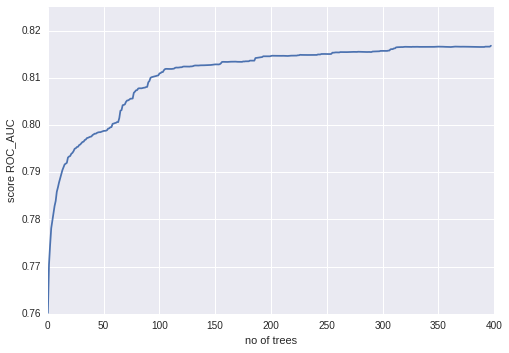

In [13]:
plt.figure()
plt.plot(tree_scores)
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Learning curve seems to decrease. I will try to find the best possible parameters. 

Perform grid search for balanced data
---------
I use grid search to look at the following hyperparameters: 
* number of trees 
  * from the previous study we know that number of trees should be higher than 300. See graph above. 
* learning rates 
    * I check range [0.05-2]  
       * I checked range [0.1-0.7]   the best scores obtained for 0.1, that why I check different region 
       
In the next step I will focus on **min_child_weight** and **max_depth** and **gamma**

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {"n_estimators": [x  for x in range(299,501) if x % 50 == 0],
                   "learning_rate": [0.05,0.07,1,1.5,2]}
print(gb_grid_params)

gb_gs = xgb.XGBClassifier(scale_pos_weight=ratio_ghost_to_good, max_depth=6)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(train_gs_X, train_gs_Y);

In [9]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'n_estimators': 500, 'learning_rate': 0.07}
Grid scores on development set:
0.794 (+/-0.005) for {'n_estimators': 300, 'learning_rate': 0.05}
0.794 (+/-0.005) for {'n_estimators': 350, 'learning_rate': 0.05}
0.795 (+/-0.006) for {'n_estimators': 400, 'learning_rate': 0.05}
0.795 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.05}
0.796 (+/-0.006) for {'n_estimators': 500, 'learning_rate': 0.05}
0.795 (+/-0.005) for {'n_estimators': 300, 'learning_rate': 0.07}
0.796 (+/-0.005) for {'n_estimators': 350, 'learning_rate': 0.07}
0.796 (+/-0.006) for {'n_estimators': 400, 'learning_rate': 0.07}
0.796 (+/-0.006) for {'n_estimators': 450, 'learning_rate': 0.07}
0.796 (+/-0.007) for {'n_estimators': 500, 'learning_rate': 0.07}
0.738 (+/-0.000) for {'n_estimators': 300, 'learning_rate': 1}
0.737 (+/-0.003) for {'n_estimators': 350, 'learning_rate': 1}
0.736 (+/-0.004) for {'n_estimators': 400, 'learning_rate': 1}
0.736 (+/-0.003) for {'n_est

Train model with obtained parameters
--------------
I use 500 trees and learning rate 0.07

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              
gb6 = xgb.XGBClassifier( n_estimators=500, learning_rate=0.07, scale_pos_weight=ratio_ghost_to_good, max_depth=6)
gb6.fit(train_X,train_Y)
joblib.dump(gb6, 'models/XGBoost_500_balanced_afterGS.pkl') 

['models/XGBoost_500_balanced_afterGS.pkl',
 'models/XGBoost_500_balanced_afterGS.pkl_01.npy',
 'models/XGBoost_500_balanced_afterGS.pkl_02.npy']

In [10]:
print "ROC AUC score of XGBoost with 500 trees and trained using scale positive weight"
roc_auc_score(test_Y, gb6.predict_proba(test_X)[:, 1])

ROC AUC score of XGBoost with 500 trees and trained using scale positive weight


0.81567448613125149

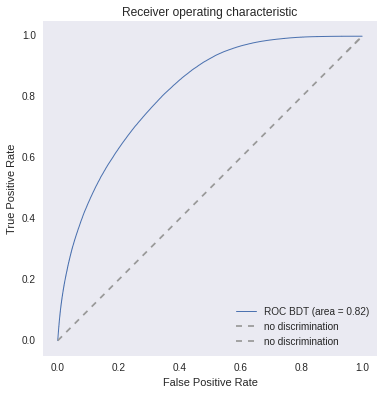

In [9]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, gb6.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

The result is the same no improvement! 
----------

The last idea is to perform grid search to find optimal values of **tree depth**, **gamma** and **min_child_weight**

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = { "min_child_weight": [1,10,20,50],
                  "max_depth": [5,6,8,10]
                 }
print(gb_grid_params)

gb_gs = xgb.XGBClassifier(n_estimators=400, learning_rate=0.07 ,scale_pos_weight=ratio_ghost_to_good)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(train_gs_X, train_gs_Y);

{'max_depth': [5, 6, 8, 10], 'min_child_weight': [1, 10, 20, 50]}
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=20 ................................
[CV] max_depth=5, min_child_weight=20 ................................
[CV] max_depth=5, min_child_weight=20 ................................
[CV] max_depth=5, min_child_weight=50 ................................


In [ ]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

The result will be committed leater! 
=========

Add linear combination and ratios of the features
-----------

As a very first step I add such features as 
* number of cluster minus number of layers
* number of hit in OT
* pseudo rapidity, momentum and transverse momentum divided by chi2 

And then I will try to find importance of it. 

In [17]:
def add_more_features(data):
    out = data
    out["seed_lhcbId-layers"] = data.seed_nLHCbIDs - data.seed_nLayers
    out["seed_ot"] = data.seed_nLHCbIDs - data.seed_nbIT
    out["seed_pr/chi2"] = data.pseudo_rapidity / data.seed_chi2PerDoF
    out["seed_p/chi2"] = data.seed_p/ data.seed_chi2PerDoF
    out["seed_tr"]= numpy.sqrt(numpy.square(data.seed_tx) +numpy.square(data.seed_ty))    
    return out

In [19]:
mf_data = add_more_features(new_data)
mf_features = mf_data.drop("is_true_seed", axis=1).astype(numpy.float64)
mf_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,...,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity,seed_lhcbId-layers,seed_ot,seed_pr/chi2,seed_p/chi2,seed_tr
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,...,517.249191,0.524220,0.061572,1364.959300,0.505958,13,25,0.416870,2095.620933,0.527823
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,...,99.363473,0.480288,0.009081,1268.420312,0.463589,13,25,0.344391,2066.311262,0.480374
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,...,196.064807,0.382802,0.025975,1533.677219,0.374842,13,25,0.230299,2930.298550,0.383682
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,...,483.850246,0.369674,0.058753,1636.317578,0.366082,13,25,0.204603,2907.907705,0.374314
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,...,411.084316,0.646627,0.054980,1692.412576,0.610352,12,24,0.480881,1812.867601,0.648960


In [20]:
mf_trainX, mf_testX, mf_trainY, mf_testY = train_test_split(mf_features, target, random_state=42,train_size=0.5 )

In [22]:
gb5 = xgb.XGBClassifier( n_estimators=400, learning_rate=0.2, max_depth=6)
gb5.fit(mf_trainX, mf_trainY)
joblib.dump(gb5, 'models/XGBoost_400trees_linearFeatures.pkl') 

['models/XGBoost_400trees_linearFeatures.pkl',
 'models/XGBoost_400trees_linearFeatures.pkl_01.npy',
 'models/XGBoost_400trees_linearFeatures.pkl_02.npy']

In [23]:
print "ROC AUC score of XGBoost with 400 trees with additional linear combination of the features"
roc_auc_score(mf_testY, gb5.predict_proba(mf_testX)[:, 1])

ROC AUC score of XGBoost with 400 trees with additional linear combination of the features


0.81894167992847922

In [24]:
tree_scores = [] 
for tree_nb in range(1,399):
    proba = gb5.predict_proba(mf_testX,ntree_limit=tree_nb)
    predicted = proba[:, 1]
    score =  roc_auc_score(mf_testY, predicted)
    print("".join(["tree ",str(tree_nb), " score ", str(score)]))
    tree_scores.append(score)

tree 1 score 0.762271105362
tree 2 score 0.766251827594
tree 3 score 0.770781878641
tree 4 score 0.771862329496
tree 5 score 0.773108018141
tree 6 score 0.774435737418
tree 7 score 0.775385457913
tree 8 score 0.776902208118
tree 9 score 0.777887759592
tree 10 score 0.778752600837
tree 11 score 0.78011598334
tree 12 score 0.781158430581
tree 13 score 0.782203193847
tree 14 score 0.782899290218
tree 15 score 0.783839083698
tree 16 score 0.784707871777
tree 17 score 0.784907310925
tree 18 score 0.785801248357
tree 19 score 0.786160359751
tree 20 score 0.787050651956
tree 21 score 0.787401555557
tree 22 score 0.788053131512
tree 23 score 0.788738802183
tree 24 score 0.789380049521
tree 25 score 0.790177228009
tree 26 score 0.790420508105
tree 27 score 0.7906021471
tree 28 score 0.791025650511
tree 29 score 0.79113598399
tree 30 score 0.791331903935
tree 31 score 0.791808551248
tree 32 score 0.791952599426
tree 33 score 0.792428008184
tree 34 score 0.792833806681
tree 35 score 0.79301036953

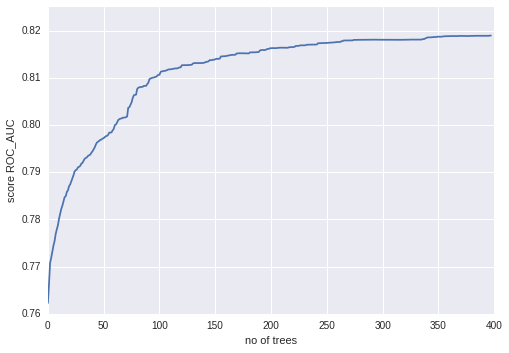

In [25]:
plt.figure()
plt.plot(tree_scores)
plt.ylim(0.76, 0.825)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Conclusion on selected linear combinations and ratios of the featured
-----------
Adding this features has no influence on classifier performance. 

Speedup the classifier
=========

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.5 )              

base_classifier = xgb.XGBClassifier(n_estimators=400, learning_rate=0.07 ,scale_pos_weight=ratio_ghost_to_good)
classifier = LookupClassifier(base_estimator=base_classifier, keep_trained_estimator=False)
classifier.fit(train_X, train_Y)

ValueError: feature_names mismatch: [u'seed_chi2PerDoF', u'seed_p', u'seed_pt', u'seed_nLHCbIDs', u'seed_nbIT', u'seed_nLayers', u'seed_x', u'seed_y', u'seed_tx', u'seed_ty', u'abs_seed_x', u'abs_seed_y', u'abs_seed_tx', u'abs_seed_ty', u'seed_r', u'pseudo_rapidity'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15']
expected seed_nbIT, abs_seed_y, abs_seed_x, seed_tx, seed_pt, seed_nLayers, seed_x, seed_y, seed_ty, pseudo_rapidity, seed_p, seed_r, abs_seed_tx, abs_seed_ty, seed_nLHCbIDs, seed_chi2PerDoF in input data
training data did not have the following fields: f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f12, f13, f10, f11, f14, f15

so ML_hep doesn't work with xgboost.  So sad :( 
---------

In [ ]:
print "ROC AUC score of binarized XGBoost with 400 trees and trained using scale positive weight"
roc_auc_score(test_Y, classifier.predict_proba(test_X)[:, 1])

Now you can go to the next model - [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/LogisticRegression.ipynb)    
=========